# Imports

In [2]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [3]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train a fastai model

In [4]:
OUT_ROOT_DIR = f"{os.getenv('PROJECT_PATH')}{project_config['images_directory']}{project_config['TKL']}_graphs/"

epoch,train_loss,valid_loss,accuracy,time
0,1.950246,1.099020,0.554945,10:55


epoch,train_loss,valid_loss,accuracy,time
0,1.565105,1.043236,0.615385,15:18
1,1.303667,1.816741,0.675824,15:24
2,1.099573,1.076882,0.802198,15:21


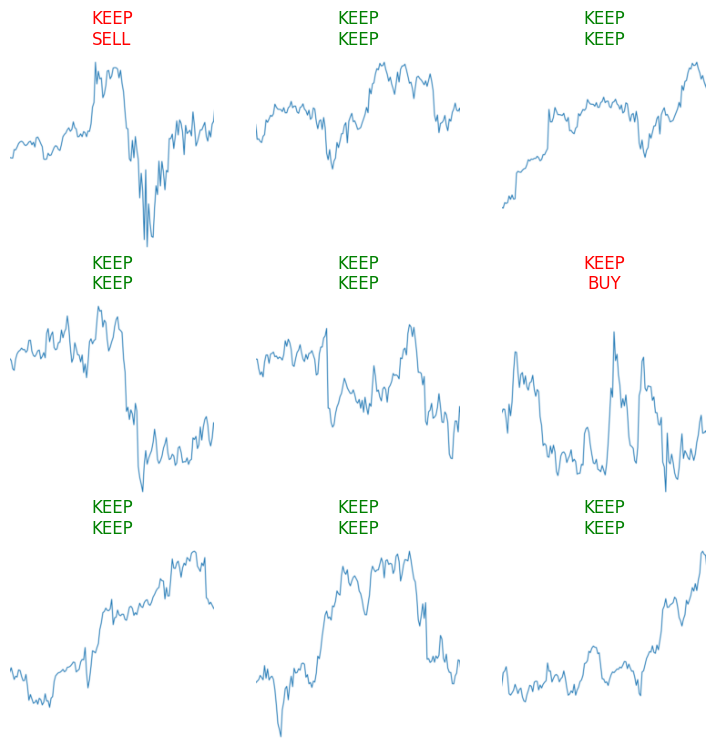

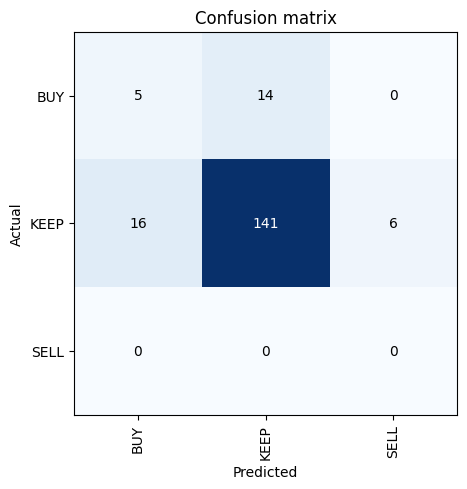

--- RECOMMANDATION FOR ONE MONTH, STARTING AT 2025-11-14 ---
File: INTC_2024-11-01_2025-11-14_BUY.png
Final Decision: KEEP

--- PROBABILITIES ---
KEEP: 0.8326
BUY: 0.1090
SELL: 0.0585


In [5]:
!pip install --upgrade fastai --quiet
from fastai.vision.all import *

# 1. Define the DataBlock
# - blocks: Image as input, Category (Buy/Sell/Keep) as output
# - get_items: find all image files recursively
# - splitter: uses the folder names 'train' and 'valid' to split data
# - get_y: parent_label gets the folder name (BUY/SELL/KEEP) as the label
dblock = DataBlock(
    #blocks=(ImageBlock, CategoryBlock),
    blocks=(ImageBlock, CategoryBlock(vocab=['BUY', 'KEEP', 'SELL'])),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224) # Ensure all graphs are the same size for the CNN
)

# 2. Load the Data
# Path points to the root directory where /train and /valid are located
dls = dblock.dataloaders(OUT_ROOT_DIR, bs=22) # Reduced batch size to 22 to prevent OOM errors

# 3. Train the Model using ResNet101
learn = vision_learner(dls, resnet101, metrics=accuracy)
learn.fine_tune(int(project_config['TRAIN_EPOCS']))
#learn.fine_tune(3)

# 4. Run Validation Results
# show_results displays actual vs predicted for the validation set
learn.show_results()
plt.show()

# Interpretation: Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.show()

# 5. Run Prediction on the 'pred' folder
# We grab the image file we saved in the /pred directory
pred_files = get_image_files(os.path.join(OUT_ROOT_DIR, "pred"))

if pred_files:
    # 1. Get the filename as a string (e.g., "AAPL_2023-01-01_2023-12-31_KEEP.png")
    fname = pred_files[0].name

    # 2. Split by underscore
    # [TKL, start_date, end_date, rec.png]
    parts = fname.split('_')

    # 3. The end date is at index 2
    end_date_str = parts[2]

    # Optional: Convert to a datetime object if you need to do math with it
    from datetime import datetime
    end_date_dt = datetime.strptime(end_date_str, '%Y-%m-%d')

if pred_files:
    # Predict the latest graph
    target_img = pred_files[0]
    pred_class, pred_idx, probs = learn.predict(target_img)

    # Get the filename as a string (e.g., "AAPL_2023-01-01_2023-12-31_KEEP.png")
    fname = pred_files[0].name

    # Split by underscore
    # [TKL, start_date, end_date, rec.png]
    parts = fname.split('_')

    # The end date is at index 2
    end_date_str = parts[2]

    print(f"--- RECOMMANDATION FOR ONE MONTH, STARTING AT {end_date_str} ---")
    print(f"File: {target_img.name}")

    #print("--- PROBABILITIES ---")
    # dls.vocab contains the list of classes (BUY, KEEP, etc.)
    # probs contains the raw decimals
    probs_map = dict(zip(dls.vocab, map(float, probs)))
    sorted_probs = sorted(probs_map.items(), key=lambda x: x[1], reverse=True)
    for category, prob in sorted_probs:
      print(f"{category}: {prob*100:.2f}%")

    print(f"Final Decision: {pred_class}\n")


else:
    print("No images found in the pred folder.")

# Save model to a pickle

In [6]:
model_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.model.fastai.pkl"
learn.export(model_path)

# Test the model with a prediciton

In [7]:
# No need to define the DataBlock or architecture again
learn_inf = load_learner(model_path)

# Run prediction
pred_class, pred_idx, probs = learn_inf.predict(target_img)

# Get the filename as a string (e.g., "AAPL_2023-01-01_2023-12-31_KEEP.png")
fname = pred_files[0].name

# Split by underscore
# [TKL, start_date, end_date, rec.png]
parts = fname.split('_')

# The end date is at index 2
end_date_str = parts[2]

print(f"----- RECOMMANDATION FOR {project_config['TKL']}. HIRIZON: ONE MONTH. START DATE: {end_date_str} -----")
#print(f"File: {target_img.name}")
#print("--- PROBABILITIES ---")
# dls.vocab contains the list of classes (BUY, KEEP, etc.)
# probs contains the raw decimals

probs_map = dict(zip(dls.vocab, map(float, probs)))
sorted_probs = sorted(probs_map.items(), key=lambda x: x[1], reverse=True)

for category, prob in sorted_probs:
  print(f"{category}: {prob*100:.2f}%")

print(f"Final Decision: {pred_class}\n")

----- RECOMMANDATION FOR INTC. HIRIZON: ONE MONTH. START DATE: 2025-11-14 -----
KEEP: 83.26%
BUY: 10.90%
SELL: 5.85%
Final Decision: KEEP

